# ECS 171 Group Project - Group 10 - ???

## Clean/Wrangle Data

"Process the data the same way the paper author did"

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import pandas as pd


#pd.options.display.max_columns = 999

#Contains 81 features extracted from 21263 superconductors along with the critical temperature in the 82nd column
train = pd.read_csv('./../superconduct/train.csv')

#Contains the chemical formula broken up for all the 21263 superconductors from the train.csv file.
#The last two columns have the critical temperature and chemical formula.
formula = pd.read_csv('./../superconduct/unique_m.csv')

print("Training Data")
print(train.shape)
print(train.head())

print("\nChemical formulas")
print(formula.shape)
print(formula.head())

Training Data
(21263, 82)
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755    

## Reference Neural Network

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

trainx = train.drop("critical_temp",axis=1)
trainy = train['critical_temp']

train_X, test_X, train_y, test_y = train_test_split(trainx,trainy, train_size=0.7, random_state=1)

sc = MinMaxScaler()

train_X = sc.fit_transform(train_X)
test_X = sc.fit_transform(test_X)

nn = Sequential(
    [
        keras.Input(shape=train_X.shape[1]),
        layers.Dense(20, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(1)
    ]
)

nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
           loss="mean_squared_error",
           metrics=[keras.metrics.MeanSquaredError()])

history = nn.fit(train_X, train_y, batch_size=64, epochs=700, verbose=0)

pred = nn.predict(test_X)
results = nn.evaluate(test_X, test_y)
print(history.history['mean_squared_error'])

200/200 [==============================] - 0s 427us/step - loss: 337.0172 - mean_squared_error: 337.0172
[845.8394775390625, 340.750244140625, 297.1322937011719, 291.7729187011719, 277.1846923828125, 265.8992919921875, 258.6407165527344, 260.66925048828125, 248.16278076171875, 244.12721252441406, 242.50747680664062, 243.7595977783203, 238.58444213867188, 239.83689880371094, 232.94664001464844, 234.96829223632812, 228.3061981201172, 224.08749389648438, 219.90884399414062, 217.903564453125, 222.96018981933594, 217.15953063964844, 210.51995849609375, 218.06680297851562, 209.47328186035156, 210.6933135986328, 208.40977478027344, 207.5788116455078, 206.78472900390625, 205.1798095703125, 205.70278930664062, 199.72872924804688, 204.8106231689453, 199.1304931640625, 197.62901306152344, 199.21202087402344, 196.01243591308594, 195.56716918945312, 191.1539306640625, 195.39048767089844, 193.71527099609375, 188.03378295898438, 197.1151123046875, 188.3515167236328, 189.58335876464844, 184.6866455078

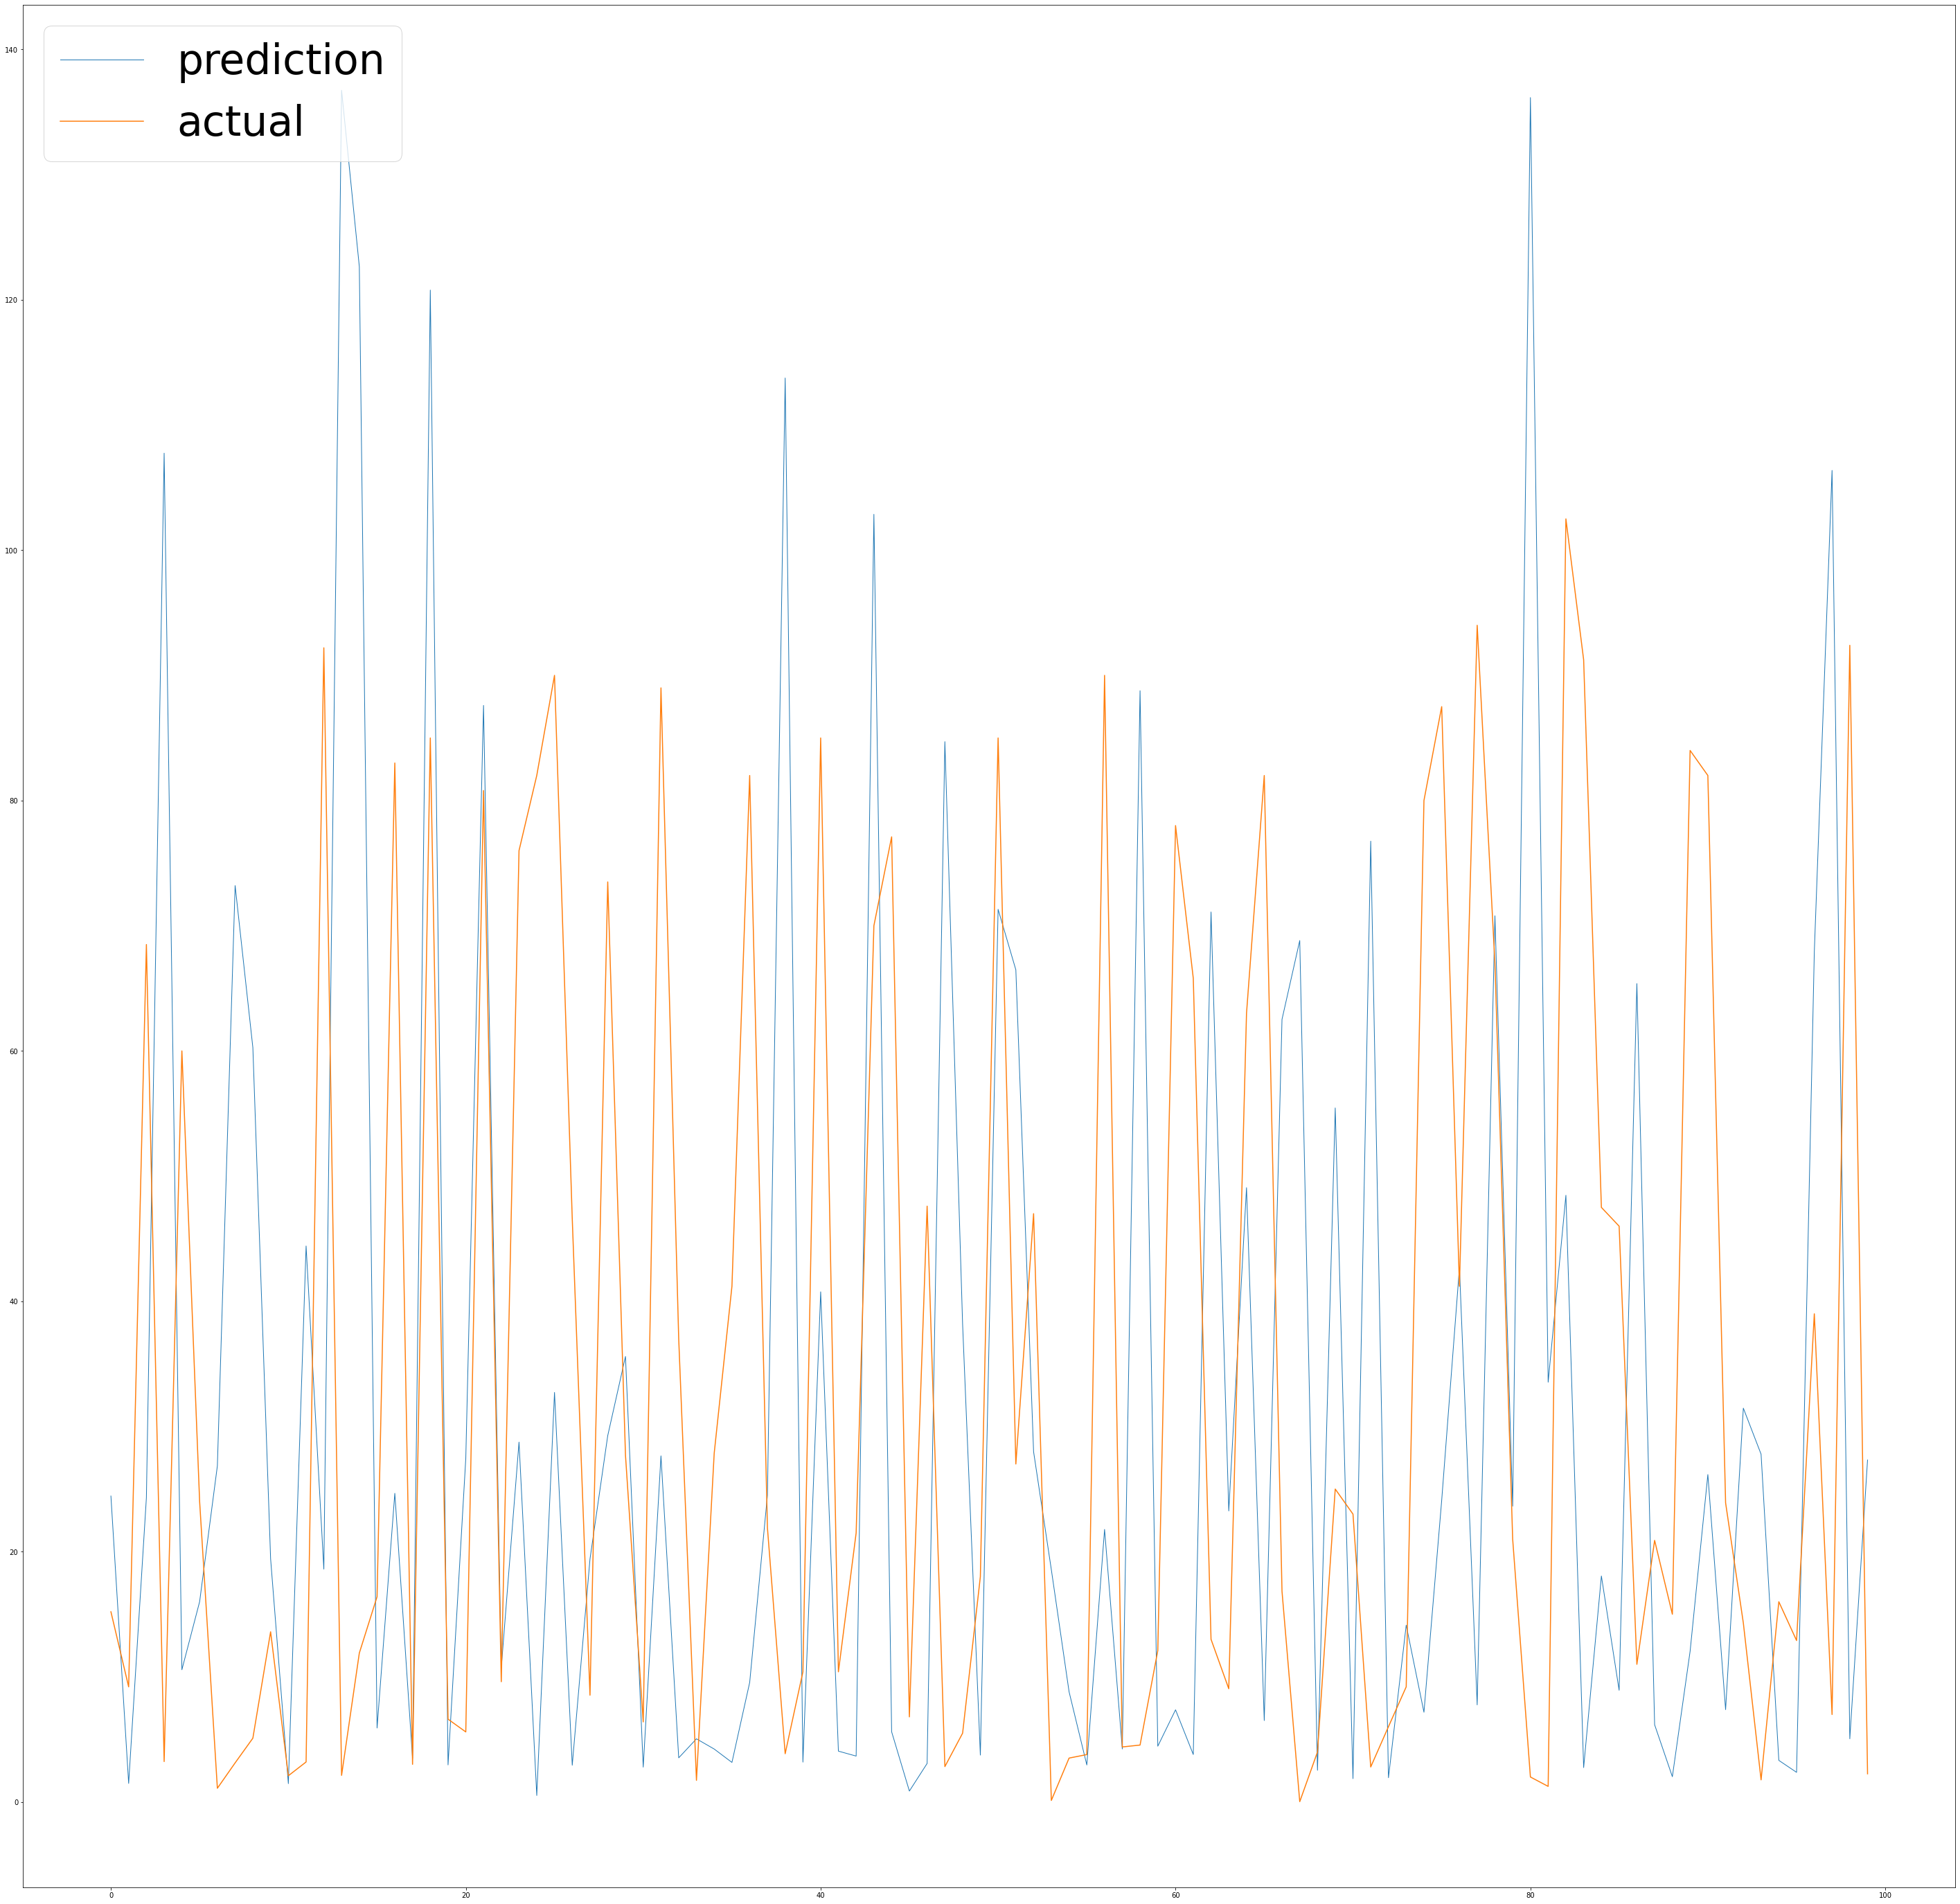

In [3]:
import matplotlib.pyplot as plt

# showing graph with first 100 values
plt.figure(figsize=(50,50))
line1 = plt.plot(range(100), pred[:100],linewidth=1, label='prediction')
line2 = plt.plot(range(100), train_y[:100], label='actual')
plt.legend(loc="upper left", prop={'size': 60})

In [4]:
# source https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
print(results)

[337.01715087890625, 337.01715087890625]


## Replicate original XGBoost model

## Optimize XGBoost model with tuned hyperparameters

## Train and test a Random Forest model

## Optimize Random Forest model with tuned hyperparameters

## Research Bayesian Neural Networks
## Train and test a Bayesian Neural Network

## Optimize Bayesian Neural Network with tuned hyperparameters

## Analyze all model results and performances

## Frontend?